In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
import ccdproc as ccdp

import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [5]:
light_file_collection = ccdp.ImageFileCollection('../reduced-lights_2022_03_22/Luminance')
data = [i for i in light_file_collection.data()]
headers = [i for i in light_file_collection.headers()]

In [17]:
import pandas as pd

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median) # Needs to be changed to local bg
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 60:
            mapping_dict[key] = np.nan
    return mapping_dict



In [18]:
dictionary_list = list()
sources_first_array = find_sources(data[0])
trimmed_sources_first_array = image_trimmer(sources_first_array, data[0])
sources_first_array_no_duplicates = excluding_duplicates(trimmed_sources_first_array, 9)

for index in range(1, len(data)):
    sources_next_array = find_sources(data[index])
    trimmed_sources_next_array = image_trimmer(sources_next_array, data[index])
    sources_next_array_no_duplicates = excluding_duplicates(trimmed_sources_next_array, 9)
    mapping_dictionary = find_nearest(sources_first_array_no_duplicates, sources_next_array_no_duplicates)
    dictionary_list.append(mapping_dictionary)

In [19]:
method_2_dict = dict()
method_2_dict[0] = list(dictionary_list[0].keys())
for index, dictionary in enumerate(dictionary_list):
    method_2_dict[index+1] = list(dictionary.values())

In [20]:
method_2_list_sources = list()

for key, item in method_2_dict.items():
    temp_list = list()
    found_sources = find_sources(data[key])
    trimmed_image = image_trimmer(found_sources, data[key])
    final_df = excluding_duplicates(trimmed_image, 9)
    for i in item:
        if i is np.nan:
            temp_list.append(np.nan)
        else:
            # temp_list.append(final_df.iloc[i]['flux'])
            temp_list.append((final_df.iloc[i]['xcentroid'], final_df.iloc[i]['ycentroid']))
    method_2_list_sources.append(temp_list)

In [21]:
all_positions_dict = dict()
for lst in method_2_list_sources:
    for index, item in enumerate(lst):
        if index not in all_positions_dict.keys():
            all_positions_dict[index] = list()
            all_positions_dict[index].append(item)
        else:
            all_positions_dict[index].append(item)

In [22]:
position_df = pd.DataFrame(all_positions_dict)

In [23]:
list(position_df.loc[0])

[(3156.391593667612, 249.55410761820283),
 (3774.8594198920496, 372.38566267875007),
 (4241.96236981832, 402.72851815537894),
 (1369.7550336227673, 483.89083075253035),
 (2199.0519797246675, 550.9346849778527),
 (3190.672778494773, 605.4737132724069),
 (3354.2446104857268, 682.0365676486966),
 (2417.4685441713764, 804.5543737335015),
 (2113.5022557994544, 855.4231643516174),
 (3391.216521271548, 907.0450796598778),
 (3066.7532748951294, 993.8922514849094),
 (358.7714824860396, 1044.1420601306495),
 (1066.390916680995, 1205.4204315269055),
 (424.6783347656137, 1374.9292357923953),
 (1858.4749063930433, 1409.2421177614299),
 (1028.294700461045, 1450.5449482930667),
 (2725.1276703531717, 1499.856904738366),
 (1151.1005412238285, 1527.174175140496),
 (913.9834305511198, 1589.852363780608),
 (2308.487891443749, 1780.9445841290465),
 (1429.7927694096968, 1863.8346547680221),
 (1201.7705481529501, 2167.8477569299785),
 (307.192308685495, 2203.48634148117),
 (3192.065009740683, 2339.4913641894

In [24]:
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import SigmaClip
import itertools

def signal_to_noise_ratio_v3(image_array, positions_df, r_start, r_end, step_size, delta_r, return_df = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    # List of the aperture radius
    aperture_radius = list()

    # List of lists with the signal-to-noise ratios at each aperture
    all_snr_list = list()

    # Empty dataframe for putting everything in later
    snr_df = pd.DataFrame()

    # Get the positions that have a nan in them and ignore them
    nan_indexes = np.argwhere(pd.isnull(positions_df))
    if nan_indexes.size > 0: # Only works with a np.array
        no_nan_positions = list(positions_df[~pd.isnull(positions_df)])
    else: # Only works with a list
        no_nan_positions = list(positions_df)

    for r in np.arange(r_start, r_end + step_size, step_size):

        annulus_aperture = CircularAnnulus(no_nan_positions, r_in = r, r_out = r + delta_r)
        bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
        bkg_median = bkg_stats.median
        apertures = CircularAperture(no_nan_positions, r)
        phot_table = aperture_photometry(image_array, apertures)
        aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
        aperture_area = aper_stats.sum_aper_area.value
        total_bkg = bkg_median * aperture_area
        phot_bkgsub = phot_table['aperture_sum'] - total_bkg
        signal_to_noise_ratio = list(phot_bkgsub / total_bkg)
        aperture_radius.append(r)
        for nan_index in nan_indexes:
            signal_to_noise_ratio.insert(nan_index[0], np.nan)
        all_snr_list.append(signal_to_noise_ratio)

    # Transpose the snr list
    stars_snr = list(map(list, itertools.zip_longest(*all_snr_list, fillvalue=None)))

    # Add the aperture radii in the first column
    snr_df['Aperture radii'] = aperture_radius

    # Create a column with the snr of each star at different radii
    for star_index, snr_list in enumerate(stars_snr):
        snr_df[f'Star {star_index}'] = snr_list

    indexes_of_max_snr = list(snr_df.idxmax())[1:] # Exclude the first one since it's the aperture radii

    optimal_radii = [snr_df['Aperture radii'].iloc[int(i)] if not np.isnan(i) else np.nan for i in indexes_of_max_snr]
    optimal_radius = np.nanmean(optimal_radii)

    if return_df:
        return snr_df
    else:
        return optimal_radius

In [25]:
def aperture_calculation(image_array, positions_df, r, delta_r, exp_time, gain, return_table = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    magnitudes_list = list()
    fluxes_list = list()
    for position in positions_df:
        if position is not np.nan:
            annulus_aperture = CircularAnnulus(position, r_in = r, r_out = r + delta_r)
            bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
            bkg_median = bkg_stats.median
            apertures = CircularAperture(position, r)
            phot_table = aperture_photometry(image_array, apertures)
            aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
            aperture_area = aper_stats.sum_aper_area.value
            total_bkg = bkg_median * aperture_area
            phot_bkgsub = phot_table['aperture_sum'] - total_bkg
            phot_table['aperture_sum_bkgsub'] = phot_bkgsub
            flux = (gain * phot_bkgsub) / exp_time
            mag = 25 - 2.5 * np.log10(flux)
            magnitudes_list.append(mag[0])
            fluxes_list.append(flux[0])
        else:
            magnitudes_list.append(np.nan)
            fluxes_list.append(np.nan)
    if return_table:
        return phot_table
    else:
        return magnitudes_list, fluxes_list

In [26]:
def calculate_magnitude(flux):
    return 25 - 2.5 * np.log10(flux)

In [27]:
all_magnitudes = list()
all_fluxes = list()
for index in range(len(position_df)):
    print(index)
    positions = np.array(position_df.loc[index])
    array = data[index]
    optimal_aperture_list = signal_to_noise_ratio_v3(array, positions, 1, 30, 0.1, 10)
    magnitudes, fluxes = aperture_calculation(array, positions, optimal_aperture_list, 10, 16, 1)
    all_fluxes.append(fluxes)
    all_magnitudes.append(magnitudes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [28]:
 # Transposing the array of all magnitudes to get the magnitudes of each star in the same list across all arrays

all_magnitudes_transposed = list(map(list, itertools.zip_longest(*all_magnitudes, fillvalue=None)))
all_fluxes_transposed = list(map(list, itertools.zip_longest(*all_fluxes, fillvalue=None)))

## Finding all the stars in the image

To find the stars in the first array we are going to use astrometry to find the RA and Dec of the image, get the corrected header and then use this to pass all the coordinates to sky coordinates. If we do this in the first array, we can then use these coordinates to find out which of the detected stars are non - variable and can be used as standards.

In [29]:
from astropy.io import fits
from astropy.wcs import WCS

# First, find all the sources in the first image

sources_first_image = excluding_duplicates(image_trimmer(find_sources(data[0]), data[0]), 9)

positions_first_image = list(zip(sources_first_image['xcentroid'], sources_first_image['ycentroid']))

for i, j in enumerate(positions_first_image):
    print(i, j)


0 (3156.391593667612, 249.55410761820283)
1 (3774.8594198920496, 372.38566267875007)
2 (4241.96236981832, 402.72851815537894)
3 (1369.7550336227673, 483.89083075253035)
4 (2199.0519797246675, 550.9346849778527)
5 (3190.672778494773, 605.4737132724069)
6 (3354.2446104857268, 682.0365676486966)
7 (2417.4685441713764, 804.5543737335015)
8 (2113.5022557994544, 855.4231643516174)
9 (3391.216521271548, 907.0450796598778)
10 (3066.7532748951294, 993.8922514849094)
11 (358.7714824860396, 1044.1420601306495)
12 (1066.390916680995, 1205.4204315269055)
13 (424.6783347656137, 1374.9292357923953)
14 (1858.4749063930433, 1409.2421177614299)
15 (1028.294700461045, 1450.5449482930667)
16 (2725.1276703531717, 1499.856904738366)
17 (1151.1005412238285, 1527.174175140496)
18 (913.9834305511198, 1589.852363780608)
19 (2308.487891443749, 1780.9445841290465)
20 (1429.7927694096968, 1863.8346547680221)
21 (1201.7705481529501, 2167.8477569299785)
22 (307.192308685495, 2203.48634148117)
23 (3192.065009740683, 

In [30]:
sources_first_image

xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  sky  \
0   3156.391594   249.554108   0.516645   -0.116155    0.116770   121  0.0   
1   3774.859420   372.385663   0.418363   -0.176082    0.113375   121  0.0   
2   4241.962370   402.728518   0.437584   -0.095012    0.199499   121  0.0   
3   1369.755034   483.890831   0.425808    0.090861    0.244910   121  0.0   
4   2199.051980   550.934685   0.498790   -0.176265   -0.116074   121  0.0   
5   3190.672778   605.473713   0.276317   -0.590181   -0.627351   121  0.0   
6   3354.244610   682.036568   0.514145   -0.009588   -0.085311   121  0.0   
7   2417.468544   804.554374   0.386714   -0.187725    0.069454   121  0.0   
8   2113.502256   855.423164   0.485280   -0.418679    0.127400   121  0.0   
9   3391.216521   907.045080   0.298627   -0.106629    0.062074   121  0.0   
10  3066.753275   993.892251   0.349440    0.164225    0.614577   121  0.0   
11   358.771482  1044.142060   0.305635    0.147286   -0.359093   121  0.0   
12  1066.390917  1205.420432   0.505245   -0.203469    0.097870   121  0.0   
13   424.678335  1374.929236   0.529527   -0.182628   -0.032334   121  0.0   
14  1858.474906  1409.242118   0.537085   -0.225601    0.032094   121  0.0   
15  1028.294700  1450.544948   0.713870    0.131049    0.284619   121  0.0   
16  2725.127670  1499.856905   0.539025    0.294188    0.335550   121  0.0   
17  1151.100541  1527.174175   0.774791   -0.289132    0.242851   121  0.0   
18   913.983431  1589.852364   0.297586   -0.209297   -0.024967   121  0.0   
19  2308.487891  1780.944584   0.393410   -0.253156    0.044437   121  0.0   
20  1429.792769  1863.834655   0.447183   -0.288297    0.031643   121  0.0   
21  1201.770548  2167.847757   0.494434   -0.123919    0.078164   121  0.0   
22   307.192309  2203.486341   0.827195    0.532264   -0.017932   121  0.0   
23  3192.065010  2339.491364   0.236605   -0.203871   -0.058910   121  0.0   
24  2151.763142  2653.238937   0.351957    0.215265   -0.471699   121  0.0   
25   345.558780  2684.932418   0.215720   -0.086818    0.086821   121  0.0   
26  3882.575068  2734.445013   0.276462   -0.336306   -0.043172   121  0.0   
27   427.116022  2776.615989   0.635888   -0.481109   -0.321759   121  0.0   
28  2492.825005  2913.999875   0.358437   -0.343543   -0.122087   121  0.0   
29  1074.012530  2952.879773   0.273174   -0.014779    0.714544   121  0.0   
30  3475.860345  2982.478506   0.600519    0.332268   -0.007779   121  0.0   
31  3012.132138  3009.824469   0.485591   -0.251587    0.217309   121  0.0   
32  3791.231703  3111.304835   0.429141   -0.080450    0.141562   121  0.0   
33  1754.199671  3141.738656   0.304495   -0.261593    0.080031   121  0.0   
34   396.773251  3296.865106   0.370493   -0.305098   -0.087506   121  0.0   
35   298.084864  3339.444113   0.388897   -0.265188    0.000179   121  0.0   

            peak        flux       mag  
0    3456.270919   17.399890 -3.101366  
1   39683.362242  209.534232 -5.803137  
2    3767.160156   19.913966 -3.247894  
3    1170.923655    6.491000 -2.030779  
4     469.121673    2.163073 -0.837678  
5     246.736171    1.748737 -0.606811  
6     601.861711    2.995944 -1.191334  
7    4402.990399   24.910592 -3.490960  
8     447.436723    2.224512 -0.868087  
9    2316.674524   14.006902 -2.865855  
10    251.509715    1.548691 -0.474912  
11  66328.605526  247.975416 -5.986022  
12   4274.321050   21.562875 -3.334267  
13   4450.624091   22.713709 -3.390720  
14   2944.439351   13.671994 -2.839580  
15    137.336261    1.025785 -0.027640  
16    197.538294    1.000082 -0.000089  
17    542.539512    2.060270 -0.784810  
18   2715.181882   16.662151 -3.054328  
19  17378.730300   87.783479 -4.858532  
20   1682.506682    8.574335 -2.333001  
21    620.757899    2.980317 -1.185656  
22    161.399031    1.042996 -0.045707  
23    296.833760    2.077593 -0.793901  
24  63145.805635  229.755728 -5.903166  
25   2053.050663   12.020549 -2.699811  
26   2171.46

In [31]:
aperture_calculation(data[0], positions_first_image, 4., 10, 16, 1, return_table= True)

<QTable length=1>
  id       xcenter       ...    aperture_sum   aperture_sum_bkgsub
             pix         ...                                      
int32      float64       ...      float64            float64      
----- ------------------ ... ----------------- -------------------
    1 298.08486413549366 ... 936720.3903416106   816550.0009022031

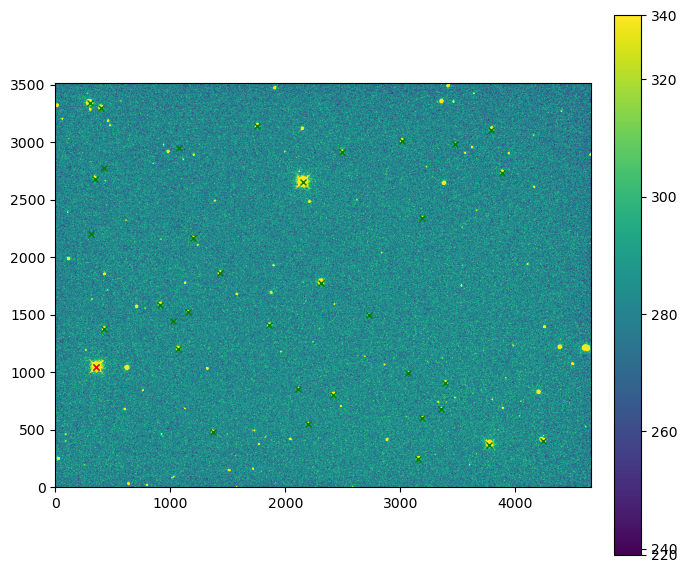

In [32]:
from convenience_functions import show_image

show_image(data[0])
for position in positions_first_image:
    plt.plot(*position,  marker = 'x', markersize = 5, color = 'green')
plt.plot(358.7714824860396, 1044.1420601306495, marker = 'x', color = 'red', markersize = 5)

In [33]:
f = fits.open('../reduced-lights_2022_03_22/Luminance/new-image.fits')
w = WCS(f[0].header)

for index, coords in enumerate(positions_first_image):
    sky = w.pixel_to_world(coords[0], coords[1]).data
    print(index, sky)
f.close()

0 (203.66962375, 54.10909637) deg
1 (203.63670658, 54.19176585) deg
2 (203.62625445, 54.25445638) deg
3 (203.63003535, 53.86734762) deg
4 (203.60791271, 53.97879824) deg
5 (203.58752834, 54.11208265) deg
6 (203.56864625, 54.13374377) deg
7 (203.54797868, 54.00703005) deg
8 (203.53881437, 53.96583589) deg
9 (203.51660003, 54.13766237) deg
10 (203.49923272, 54.09356964) deg
11 (203.51077241, 53.7283004) deg
12 (203.46768057, 53.82297388) deg
13 (203.43474501, 53.73555153) deg
14 (203.41411418, 53.92876406) deg
15 (203.41202051, 53.81661324) deg
16 (203.38586907, 54.04509151) deg
17 (203.39340831, 53.83279157) deg
18 (203.3812396, 53.80048807) deg
19 (203.32500825, 53.98754074) deg
20 (203.31392707, 53.86865881) deg
21 (203.24655577, 53.83631509) deg
22 (203.24696387, 53.71540385) deg
23 (203.18898007, 54.103677) deg
24 (203.12656573, 53.96182574) deg
25 (203.1368739, 53.71797677) deg
26 (203.09197023, 54.19454486) deg
27 (203.11516405, 53.72848208) deg
28 (203.06358213, 54.00637333) deg


By looking at their positions and crossing that with SIMBAD we can see which of these sources are stars we can use as local standards. For this particular case the list is

`stars_index = [0,2,13,25,33,34]`

and RV UMa is star 34 in the first array

In [34]:
RV_UMa_index = 19

RV_UMa_magnitudes = [all_magnitudes_transposed[RV_UMa_index]]
RV_UMa_fluxes = [all_fluxes_transposed[RV_UMa_index]]

In [39]:
saturated_stars_and_RV_UMa = [1,11,19,24,35]
stars_index =[i for i in range(len(sources_first_image)) if i not in saturated_stars_and_RV_UMa]

stars_index

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [40]:
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in stars_index]
flux_list_standard_stars = [all_fluxes_transposed[i] for i in stars_index]

We can plot all these stars to see which of them can be useful, since the nearest neighbours algorithm is not perfect.

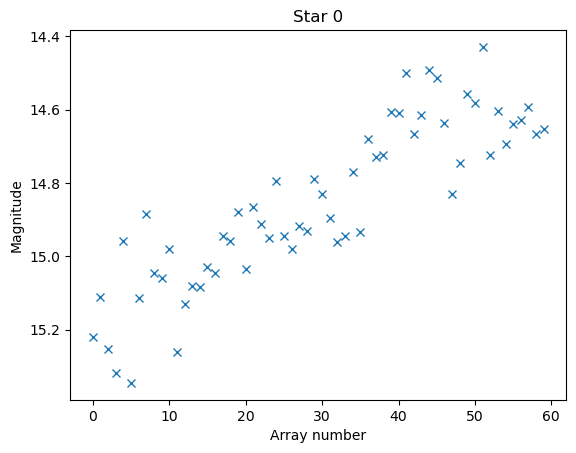

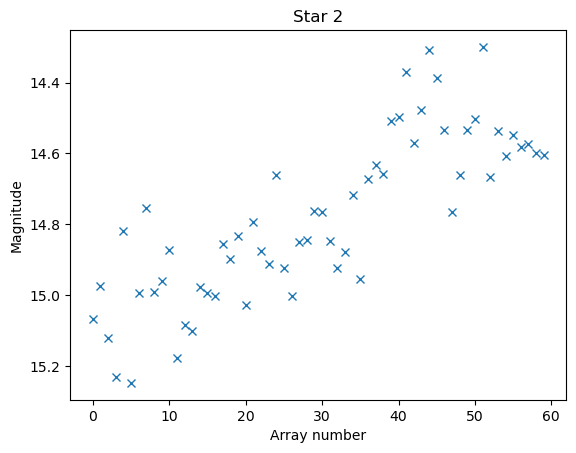

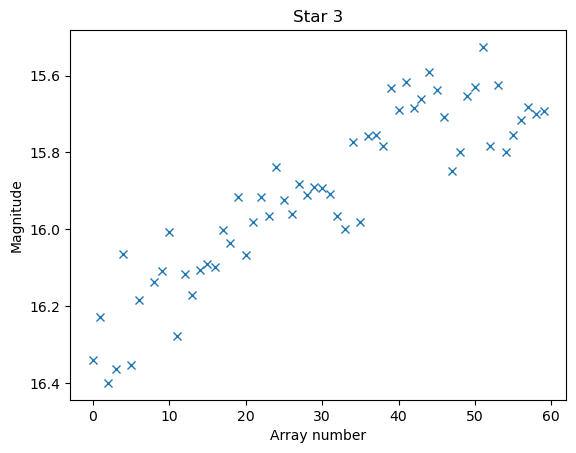

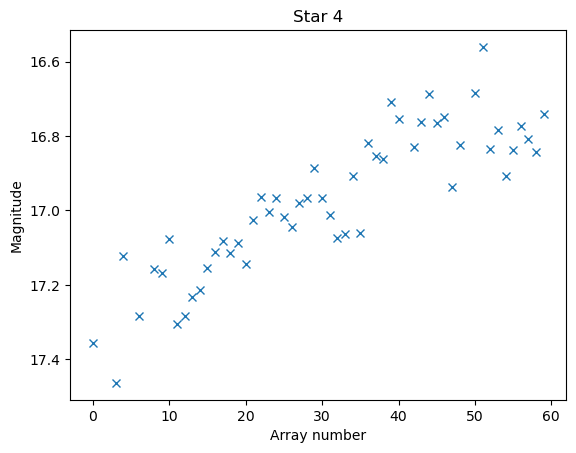

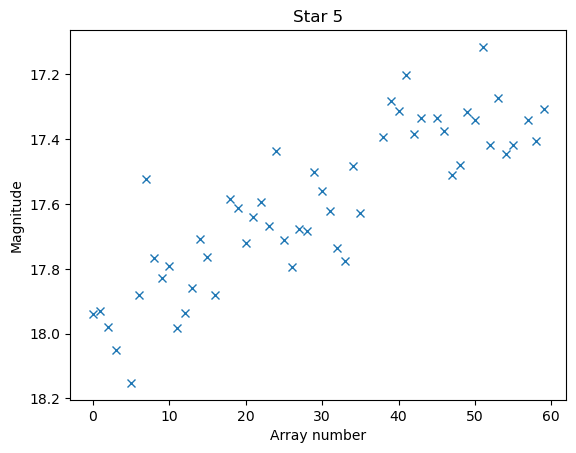

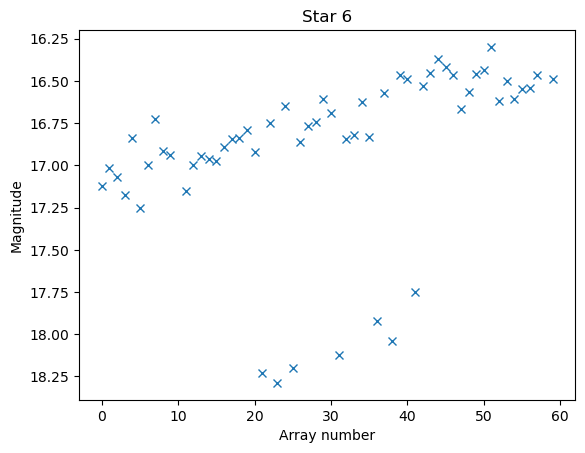

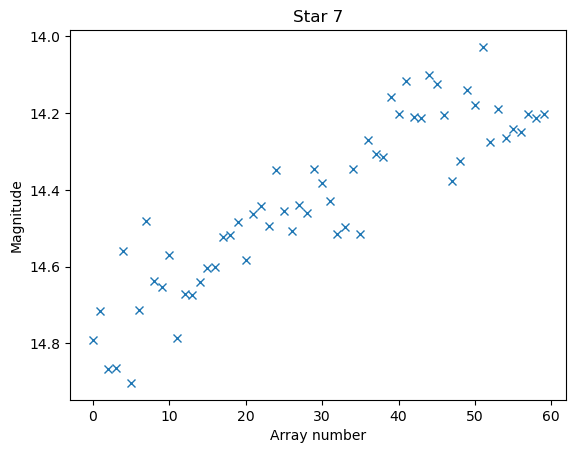

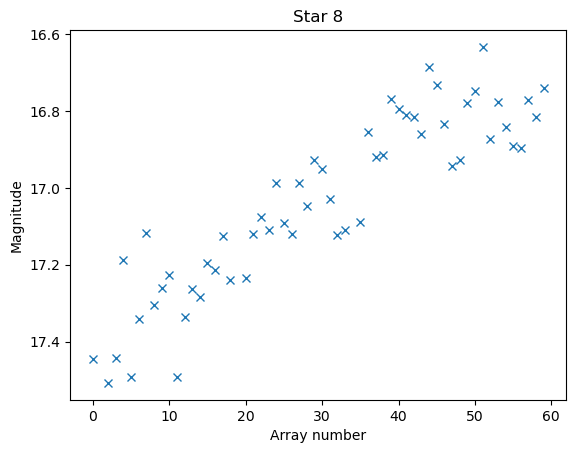

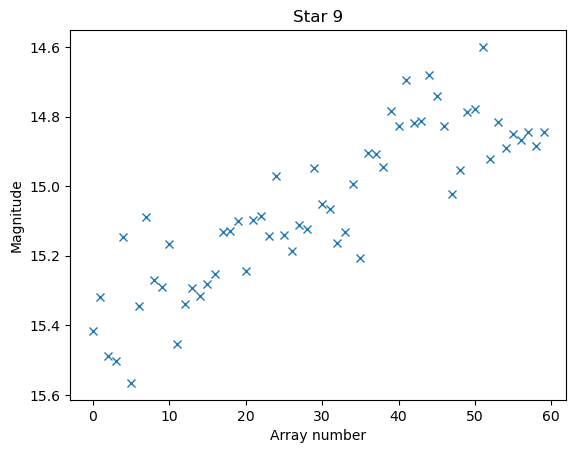

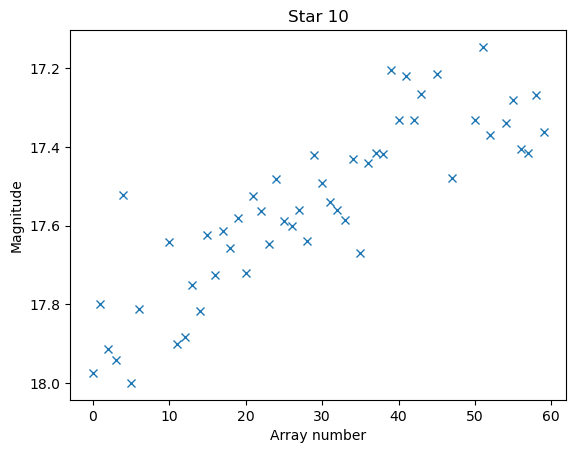

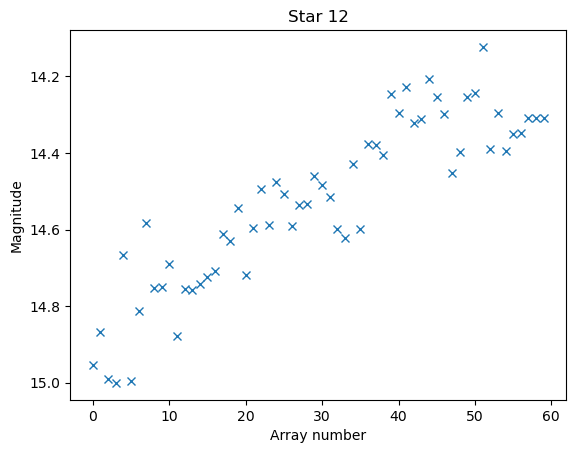

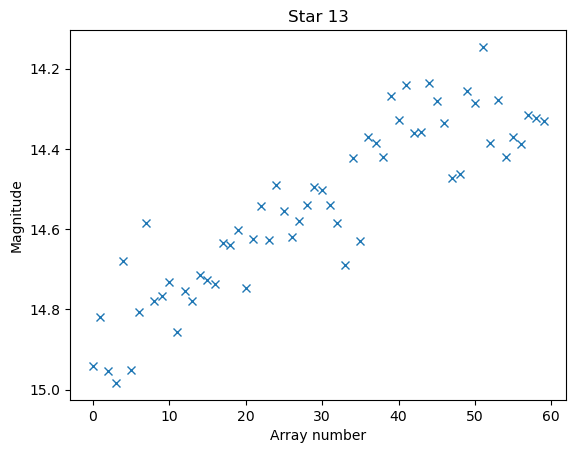

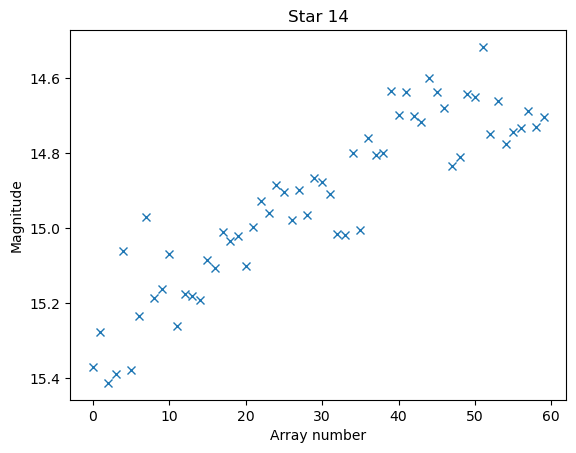

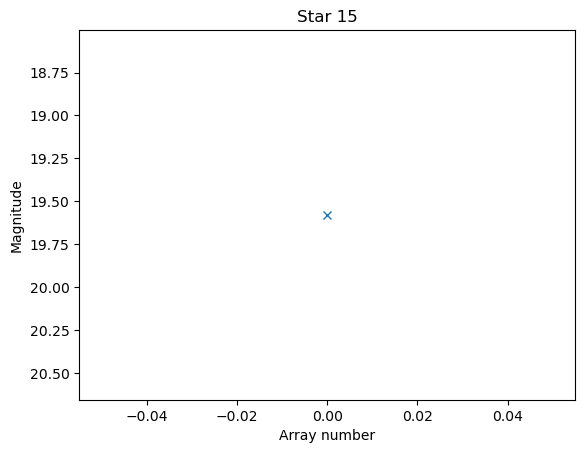

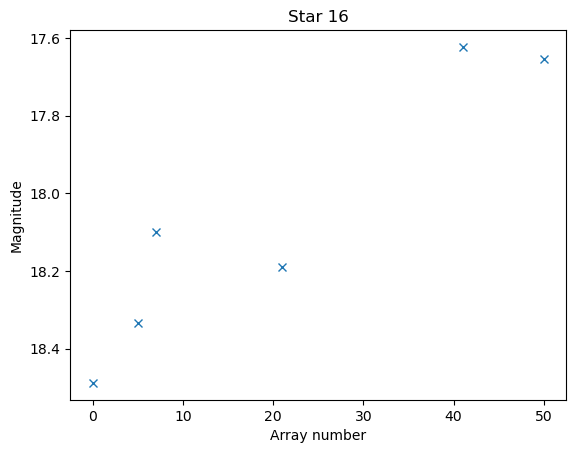

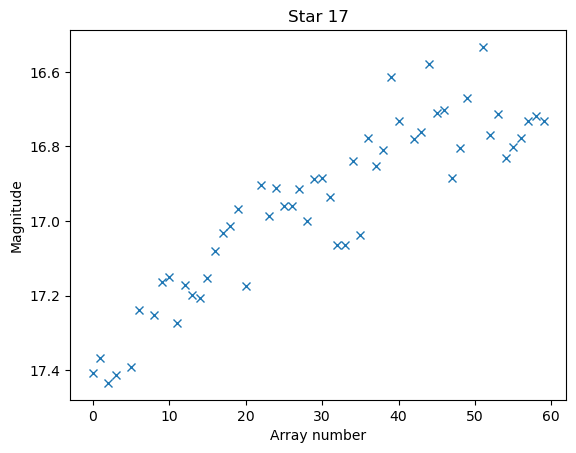

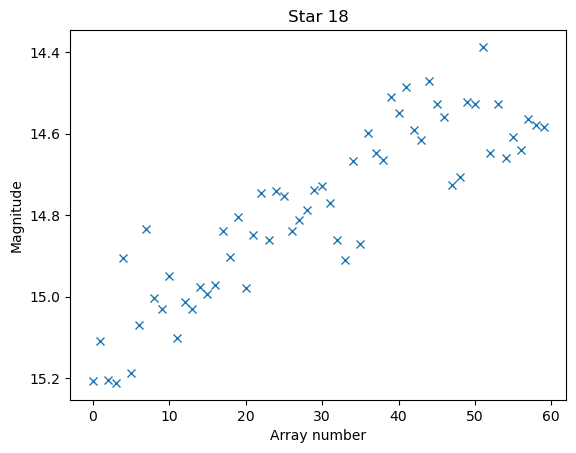

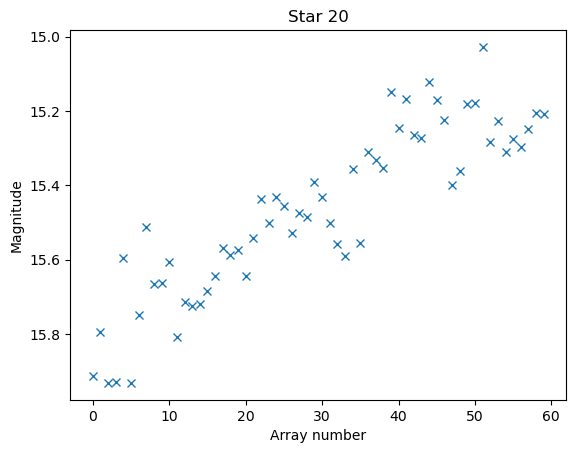

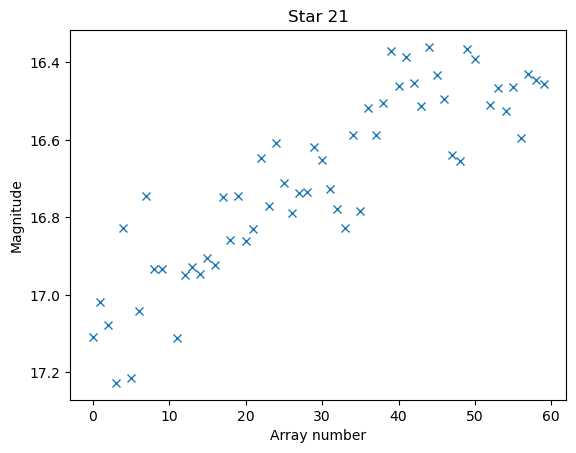

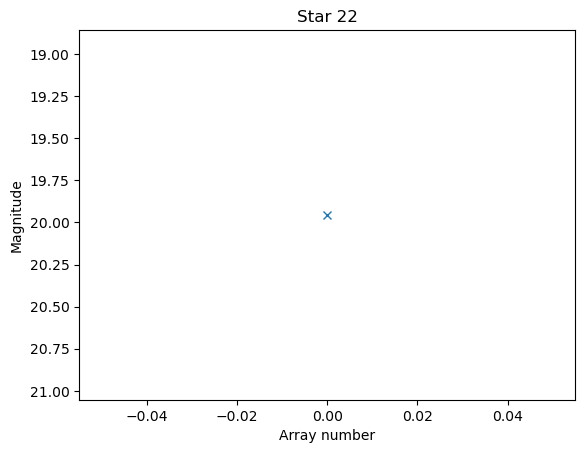

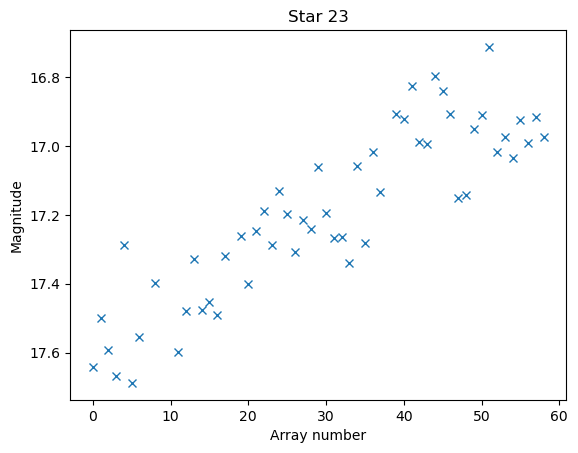

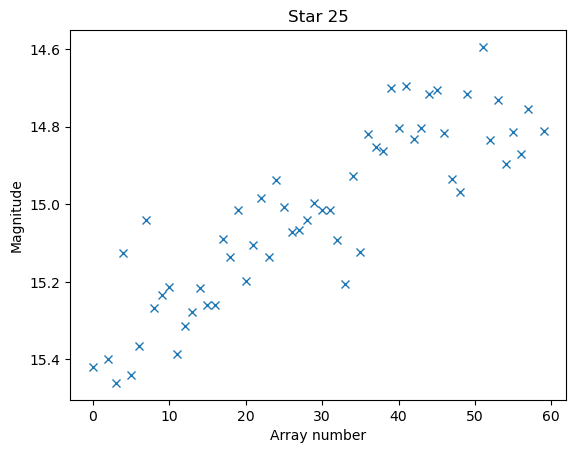

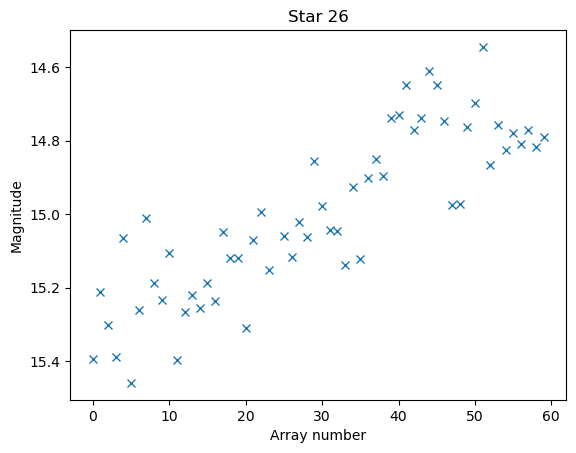

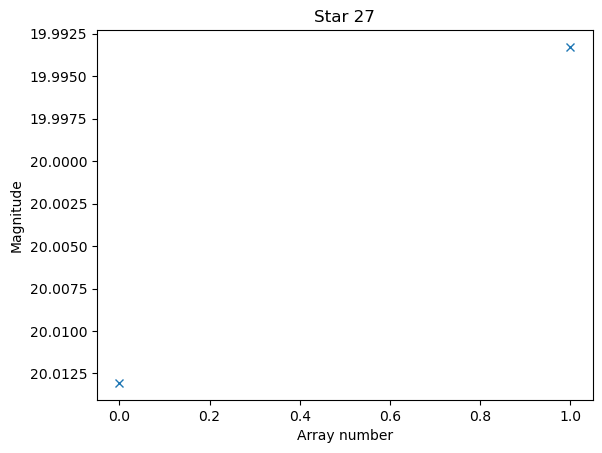

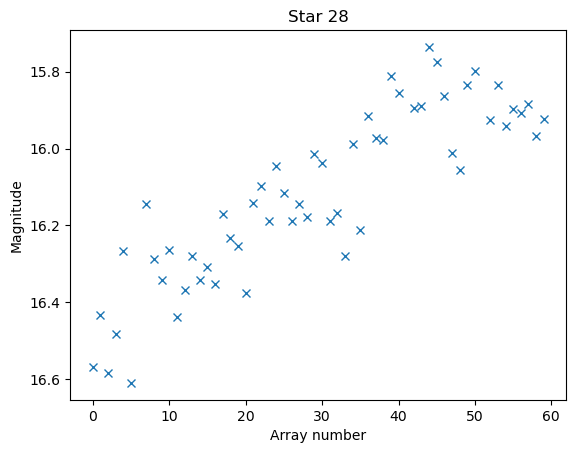

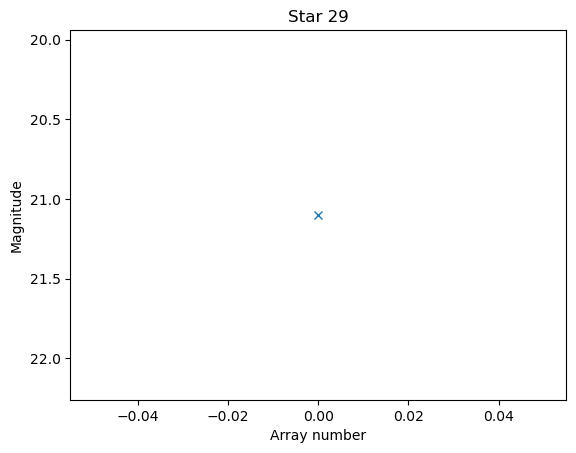

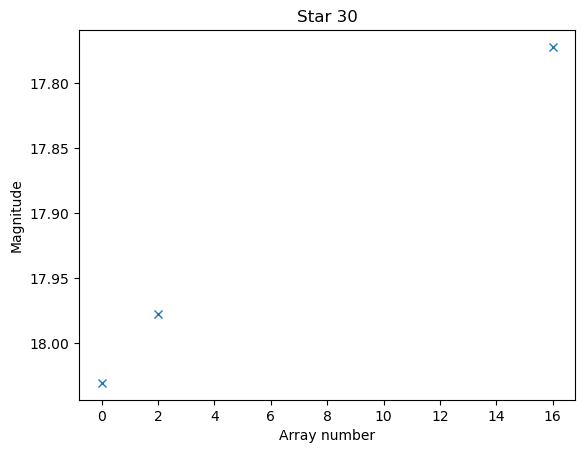

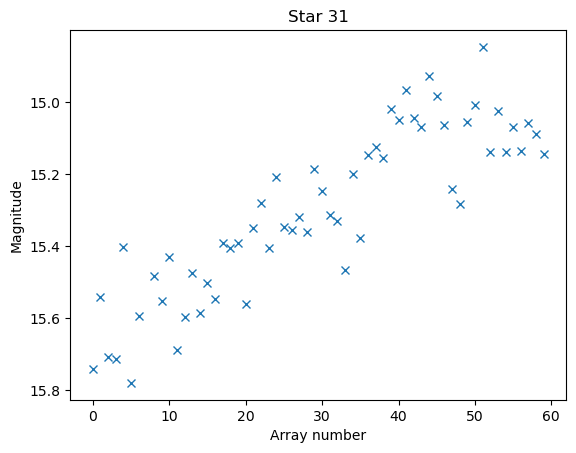

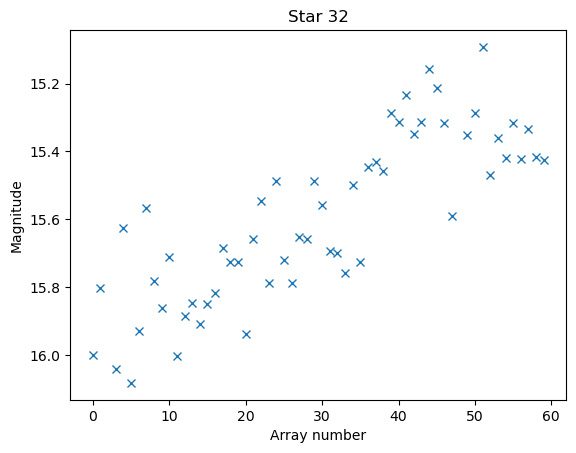

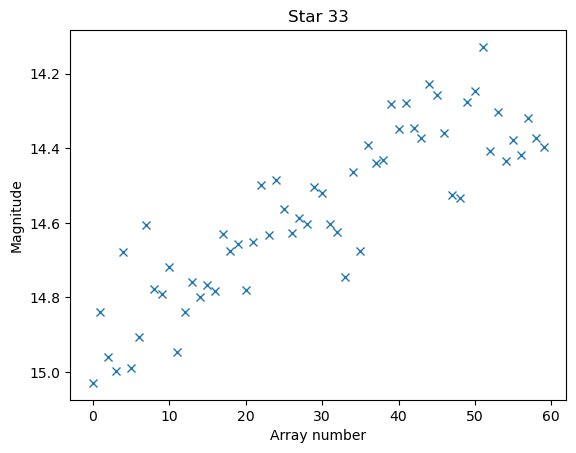

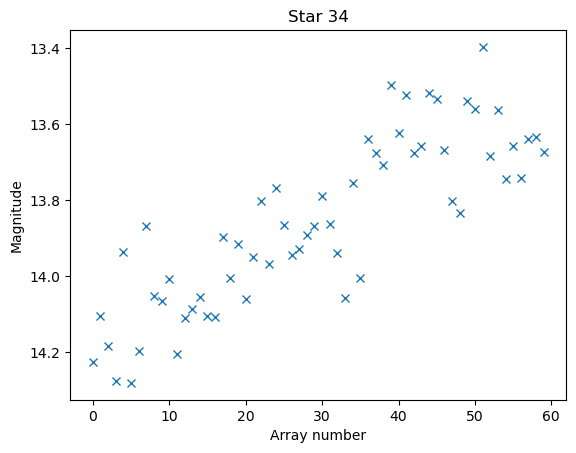

In [41]:
for index, lst in enumerate(magnitude_list_standard_stars):
    plt.plot(lst, 'x')
    plt.title(f'Star {stars_index[index]}')
    plt.xlabel('Array number')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()

Looking at these images, we can clearly tell there are some problems with star 19, star 41 and star 50. Star 58 also has one in the middle which is clearly not matching the other ones. These ones may be skewing our correction for RV UMa, so let's remove them.

In [44]:
# Removing the arrays with several errors
bad_stars_index = [1,6,7,11,12,15,16,19,20,22,24,26,27,29,30,35]
corrected_stars_index = [i for i in range(len(sources_first_image)) if i not in bad_stars_index]

flux_list_standard_stars = [all_fluxes_transposed[i] for i in corrected_stars_index]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in corrected_stars_index]

# Now we remove the item in the last array that is a bit weird and substitute it with a nan

max_index = np.nanargmax(flux_list_standard_stars[1])

flux_list_standard_stars[1][max_index] = np.nan
magnitude_list_standard_stars[1][max_index] = np.nan

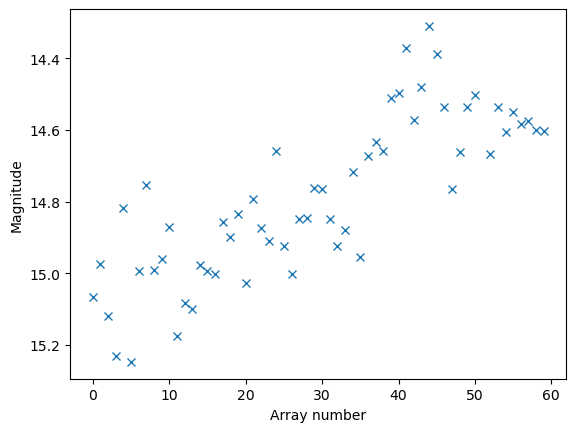

In [45]:
# Check if everything is correct

plt.plot(magnitude_list_standard_stars[1], 'x')
plt.xlabel('Array number')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

In [46]:
# Now we transpose the all_magnitudes list so that each list contains all the magnitudes of each star
all_flux_offsets_standard_stars = list()
all_magnitude_offsets_standard_stars = list()
for index, flux_list in enumerate(all_fluxes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_flux_offsets_standard_stars.append(offset)

for index, flux_list in enumerate(all_magnitudes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_magnitude_offsets_standard_stars.append(offset)

In [47]:
mean_magnitude_offsets = np.nanmean(all_magnitude_offsets_standard_stars, axis = 0)
mean_flux_offsets = np.nanmean(all_flux_offsets_standard_stars, axis = 0)

std_magnitude_offsets = np.nanstd(all_magnitude_offsets_standard_stars, axis = 0)
std_flux_offsets = np.nanstd(all_flux_offsets_standard_stars, axis = 0)

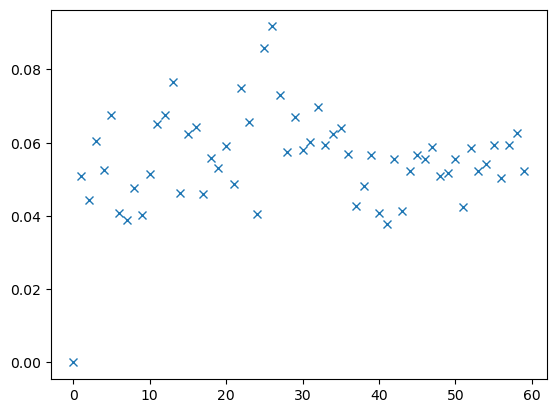

In [48]:
plt.plot(std_magnitude_offsets, 'x')

In [49]:
from operator import add
corrected_RV_UMa_flux = list(map(add, RV_UMa_fluxes, mean_flux_offsets))[0]
corrected_RV_UMa_magnitude = list(map(add, RV_UMa_magnitudes, mean_magnitude_offsets))[0]

In [51]:
corrected_RV_UMa_magnitude

array([13.25029135, 13.13352576, 13.29023893, 13.27649157, 12.95679597,
       13.33181736, 13.16768835, 12.88003274, 13.09651437, 13.11390283,
       13.01925897, 13.2965877 , 13.1573157 , 13.15936172, 13.18931205,
       13.15325498, 13.13558064, 13.03742919, 13.06706159, 13.04316974,
       13.18067339, 13.03484198, 12.96245822, 13.05753004, 12.95536927,
       13.03243598, 13.09681774, 13.03412672, 13.07956899, 12.93225868,
       12.99239085, 13.09376168, 13.14064126, 13.20439106, 12.97648287,
       13.18589593, 12.92142039, 12.97960473, 12.99298631, 12.81802923,
       12.88869408, 12.8115322 , 12.92385794, 12.94041801, 12.81366134,
       12.87997747, 12.94292138, 13.11803353, 13.11485085, 12.92442188,
       12.90768932, 12.77198311, 13.06450853, 12.9474562 , 13.08663795,
       13.04832849, 13.05883556, 13.01701084, 13.04715831, 13.04158194])

# Stuff for the presentation

In [52]:
test_sources_first_array = excluding_duplicates(image_trimmer(find_sources(data[0]), data[0]), 9)
test_sources_last_array = excluding_duplicates(image_trimmer(find_sources(data[-1]), data[-1]), 9)

In [53]:
test_sources_first_array

xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  sky  \
0   3156.391594   249.554108   0.516645   -0.116155    0.116770   121  0.0   
1   3774.859420   372.385663   0.418363   -0.176082    0.113375   121  0.0   
2   4241.962370   402.728518   0.437584   -0.095012    0.199499   121  0.0   
3   1369.755034   483.890831   0.425808    0.090861    0.244910   121  0.0   
4   2199.051980   550.934685   0.498790   -0.176265   -0.116074   121  0.0   
5   3190.672778   605.473713   0.276317   -0.590181   -0.627351   121  0.0   
6   3354.244610   682.036568   0.514145   -0.009588   -0.085311   121  0.0   
7   2417.468544   804.554374   0.386714   -0.187725    0.069454   121  0.0   
8   2113.502256   855.423164   0.485280   -0.418679    0.127400   121  0.0   
9   3391.216521   907.045080   0.298627   -0.106629    0.062074   121  0.0   
10  3066.753275   993.892251   0.349440    0.164225    0.614577   121  0.0   
11   358.771482  1044.142060   0.305635    0.147286   -0.359093   121  0.0   
12  1066.390917  1205.420432   0.505245   -0.203469    0.097870   121  0.0   
13   424.678335  1374.929236   0.529527   -0.182628   -0.032334   121  0.0   
14  1858.474906  1409.242118   0.537085   -0.225601    0.032094   121  0.0   
15  1028.294700  1450.544948   0.713870    0.131049    0.284619   121  0.0   
16  2725.127670  1499.856905   0.539025    0.294188    0.335550   121  0.0   
17  1151.100541  1527.174175   0.774791   -0.289132    0.242851   121  0.0   
18   913.983431  1589.852364   0.297586   -0.209297   -0.024967   121  0.0   
19  2308.487891  1780.944584   0.393410   -0.253156    0.044437   121  0.0   
20  1429.792769  1863.834655   0.447183   -0.288297    0.031643   121  0.0   
21  1201.770548  2167.847757   0.494434   -0.123919    0.078164   121  0.0   
22   307.192309  2203.486341   0.827195    0.532264   -0.017932   121  0.0   
23  3192.065010  2339.491364   0.236605   -0.203871   -0.058910   121  0.0   
24  2151.763142  2653.238937   0.351957    0.215265   -0.471699   121  0.0   
25   345.558780  2684.932418   0.215720   -0.086818    0.086821   121  0.0   
26  3882.575068  2734.445013   0.276462   -0.336306   -0.043172   121  0.0   
27   427.116022  2776.615989   0.635888   -0.481109   -0.321759   121  0.0   
28  2492.825005  2913.999875   0.358437   -0.343543   -0.122087   121  0.0   
29  1074.012530  2952.879773   0.273174   -0.014779    0.714544   121  0.0   
30  3475.860345  2982.478506   0.600519    0.332268   -0.007779   121  0.0   
31  3012.132138  3009.824469   0.485591   -0.251587    0.217309   121  0.0   
32  3791.231703  3111.304835   0.429141   -0.080450    0.141562   121  0.0   
33  1754.199671  3141.738656   0.304495   -0.261593    0.080031   121  0.0   
34   396.773251  3296.865106   0.370493   -0.305098   -0.087506   121  0.0   
35   298.084864  3339.444113   0.388897   -0.265188    0.000179   121  0.0   

            peak        flux       mag  
0    3456.270919   17.399890 -3.101366  
1   39683.362242  209.534232 -5.803137  
2    3767.160156   19.913966 -3.247894  
3    1170.923655    6.491000 -2.030779  
4     469.121673    2.163073 -0.837678  
5     246.736171    1.748737 -0.606811  
6     601.861711    2.995944 -1.191334  
7    4402.990399   24.910592 -3.490960  
8     447.436723    2.224512 -0.868087  
9    2316.674524   14.006902 -2.865855  
10    251.509715    1.548691 -0.474912  
11  66328.605526  247.975416 -5.986022  
12   4274.321050   21.562875 -3.334267  
13   4450.624091   22.713709 -3.390720  
14   2944.439351   13.671994 -2.839580  
15    137.336261    1.025785 -0.027640  
16    197.538294    1.000082 -0.000089  
17    542.539512    2.060270 -0.784810  
18   2715.181882   16.662151 -3.054328  
19  17378.730300   87.783479 -4.858532  
20   1682.506682    8.574335 -2.333001  
21    620.757899    2.980317 -1.185656  
22    161.399031    1.042996 -0.045707  
23    296.833760    2.077593 -0.793901  
24  63145.805635  229.755728 -5.903166  
25   2053.050663   12.020549 -2.699811  
26   2171.46

In [54]:
test_sources_last_array

xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  sky  \
0   1761.896931   183.539627   0.693277    0.264348   -0.063755   121  0.0   
1    297.727936   213.283678   0.207069   -0.639206    0.461373   121  0.0   
2   3198.631235   275.130564   0.394684    0.126281   -0.229341   121  0.0   
3   3344.629925   308.420927   0.465689   -0.062916    0.349196   121  0.0   
4   3817.039183   398.418195   0.460060    0.091358   -0.195485   121  0.0   
5   4283.939992   429.098243   0.452520    0.091819   -0.225960   121  0.0   
6   1411.786710   508.705954   0.405548    0.228202   -0.068477   121  0.0   
7   2241.506745   575.856561   0.524695    0.332811   -0.221928   121  0.0   
8   3232.886525   631.362353   0.601242    0.373361   -0.231212   121  0.0   
9   3396.685465   707.458533   0.617712    0.184317   -0.204671   121  0.0   
10  3839.320812   787.106128   0.509035    0.002218    0.113776   121  0.0   
11  2459.377005   829.790031   0.396339    0.192494   -0.138665   121  0.0   
12  2155.819998   880.241866   0.482488    0.195882   -0.200132   121  0.0   
13  3433.262206   932.593467   0.384867    0.248205   -0.207565   121  0.0   
14  3108.530327  1019.214104   0.638294    0.244618   -0.181448   121  0.0   
15   400.384245  1068.196383   0.327248   -0.430481   -0.400357   121  0.0   
16   437.262689  1105.681697   0.263620    0.425090   -0.055363   121  0.0   
17  2733.149723  1160.560091   0.292417    0.250809   -0.450622   121  0.0   
18  2001.558367  1200.987175   0.566582    0.079721   -0.063569   121  0.0   
19  1108.292235  1229.923302   0.468441    0.175786   -0.093599   121  0.0   
20  2283.505707  1286.327797   0.528442    0.170342   -0.217946   121  0.0   
21   466.612770  1399.520788   0.529977    0.046805   -0.061888   121  0.0   
22  1900.229163  1434.107940   0.474326    0.304121   -0.144995   121  0.0   
23  1193.219543  1550.804777   0.464373    0.175161   -0.154378   121  0.0   
24   955.801036  1614.564077   0.525361    0.167484   -0.102021   121  0.0   
25   363.289596  1656.254868   0.451318    0.123705   -0.379966   121  0.0   
26  1919.443079  1715.734335   0.242963    0.274415   -0.153951   121  0.0   
27  2349.989096  1805.960685   0.420387    0.336240   -0.168649   121  0.0   
28  1471.328289  1888.727764   0.388114    0.152590   -0.163590   121  0.0   
29  1939.219186  1950.210213   0.519656    0.232714   -0.068632   121  0.0   
30  2878.974564  2059.687624   0.844061   -0.009763    0.128104   121  0.0   
31  1283.108634  2128.693029   0.768111    0.164117   -0.260488   121  0.0   
32  1243.792010  2192.499661   0.495832    0.209234   -0.227591   121  0.0   
33  2755.658103  2226.652765   0.783774   -0.402997   -0.301641   121  0.0   
34   679.553650  2397.491564   0.266465   -0.151330    0.322006   121  0.0   
35  3703.842836  2428.043667   0.931804   -0.083245   -0.211834   121  0.0   
36  2251.464855  2505.382101   0.372800    0.486529   -0.137974   121  0.0   
37  4203.030147  2631.488657   0.528362   -0.001724   -0.083182   121  0.0   
38  2191.205962  2677.926158   0.291318   -0.437577   -0.201804   121  0.0   
39   387.837585  2709.462279   0.392661    0.056897    0.014447   121  0.0   
40  3923.491478  2760.287413   0.534693    0.080829   -0.222231   121  0.0   
41  3269.042236  2807.657803   0.498152   -0.184951   -0.166116   121  0.0   
42  1246.874630  2912.123704   0.488190    0.239711   -0.061579   121  0.0   
43  2534.108567  2939.262595   0.320744    0.370752   -0.127393   121  0.0   
44  3052.832234  3034.835256   0.516261    0.291164   -0.052163   121  0.0   
45  3832.114982  3136.566041   0.529286    0.326613   -0.309801   121  0.0   
46  1795.594391  3166.587148   0.387339    0.373737   -0.066946   121  0.0   
47   502.561059  3207.812365   0.522112    0.104192   -0.065290   121  0.0   
48   438.695711  3321.373968   0.430588    0.024554   -0.013041   121  0.0   

            peak        flux       mag  
0     769.772869    5.603253 -1.871101  
1      64.769078    1.0

In [55]:
dict_presentation = find_nearest(test_sources_first_array, test_sources_last_array)

In [56]:
dict_presentation

{0: 2,
 1: 4,
 2: 5,
 3: 6,
 4: 7,
 5: 8,
 6: 9,
 7: 11,
 8: 12,
 9: 13,
 10: 14,
 11: 15,
 12: 19,
 13: 21,
 14: 22,
 15: nan,
 16: nan,
 17: 23,
 18: 24,
 19: 27,
 20: 28,
 21: 32,
 22: nan,
 23: nan,
 24: 38,
 25: 39,
 26: 40,
 27: nan,
 28: 43,
 29: nan,
 30: nan,
 31: 44,
 32: 45,
 33: 46,
 34: 48,
 35: nan}

In [57]:
for key in dict_presentation.keys():
    if key in corrected_stars_index:
        print(key, dict_presentation[key])

0 2
2 5
3 6
4 7
5 8
8 12
9 13
10 14
13 21
14 22
17 23
18 24
21 32
23 nan
25 39
28 43
31 44
32 45
33 46
34 48


In [58]:
last_array_mapping = [2,5,21,39,46,48]

In [59]:
list(zip(test_sources_first_array.iloc[corrected_stars_index]['xcentroid'], test_sources_first_array.iloc[corrected_stars_index]['ycentroid']))

[(3156.391593667612, 249.55410761820283),
 (4241.96236981832, 402.72851815537894),
 (1369.7550336227673, 483.89083075253035),
 (2199.0519797246675, 550.9346849778527),
 (3190.672778494773, 605.4737132724069),
 (2113.5022557994544, 855.4231643516174),
 (3391.216521271548, 907.0450796598778),
 (3066.7532748951294, 993.8922514849094),
 (424.6783347656137, 1374.9292357923953),
 (1858.4749063930433, 1409.2421177614299),
 (1151.1005412238285, 1527.174175140496),
 (913.9834305511198, 1589.852363780608),
 (1201.7705481529501, 2167.8477569299785),
 (3192.065009740683, 2339.491364189462),
 (345.5587801311043, 2684.932418493146),
 (2492.825005212155, 2913.999875053484),
 (3012.1321379251262, 3009.824469399487),
 (3791.2317026435676, 3111.3048347564613),
 (1754.1996705503554, 3141.7386564632407),
 (396.773250967703, 3296.865105632183)]

In [60]:
list(zip(test_sources_last_array.iloc[last_array_mapping]['xcentroid'], test_sources_last_array.iloc[last_array_mapping]['ycentroid']))

[(3198.6312350867915, 275.13056433320367),
 (4283.939991823673, 429.0982434051284),
 (466.61276952428346, 1399.5207879354884),
 (387.837585300374, 2709.4622790306116),
 (1795.594390834655, 3166.587148487002),
 (438.69571061757875, 3321.373967753316)]

1760.0 2328.0


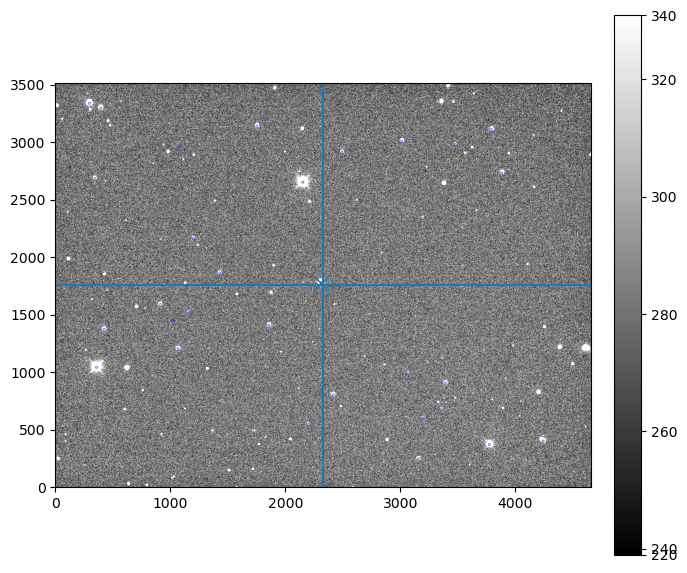

In [61]:
positions = np.transpose((test_sources_first_array['xcentroid'], test_sources_first_array['ycentroid']))

apertures = CircularAperture(positions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

show_image(data[0], cmap = 'gray')

apertures.plot(color='blue', lw=1.5, alpha=0.5)

plt.plot(2308, 1780, marker = 'x', markersize = 10)

plt.axhline(data[0].shape[0]/2)

plt.axvline(data[1].shape[1]/2);

print(data[0].shape[0]/2, data[1].shape[1]/2)

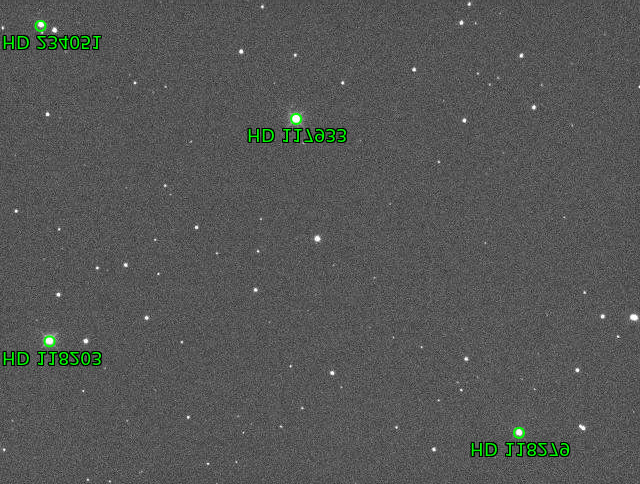

In [62]:
from PIL import Image, ImageOps
from IPython.display import  display

img = Image.open('20220322_detected_sources.jpg')
img = ImageOps.flip(img)
display(img)

In [63]:
first_array_sources_positions = [(3156.391593667612, 249.55410761820283),
                                 (4241.96236981832, 402.72851815537894),
                                 (424.6783347656137, 1374.9292357923953),
                                 (345.5587801311043, 2684.932418493146),
                                 (1754.1996705503554, 3141.7386564632407),
                                 (396.773250967703, 3296.865105632183)]

In [64]:
last_array_sources_positions = [(3198.6312350867915, 275.13056433320367),
                                (4283.939991823673, 429.0982434051284),
                                (466.61276952428346, 1399.5207879354884),
                                (387.837585300374, 2709.4622790306116),
                                (1795.594390834655, 3166.587148487002),
                                (438.69571061757875, 3321.373967753316)]

In [65]:
corrected_stars_index

[0, 2, 3, 4, 5, 8, 9, 10, 13, 14, 17, 18, 21, 23, 25, 28, 31, 32, 33, 34]

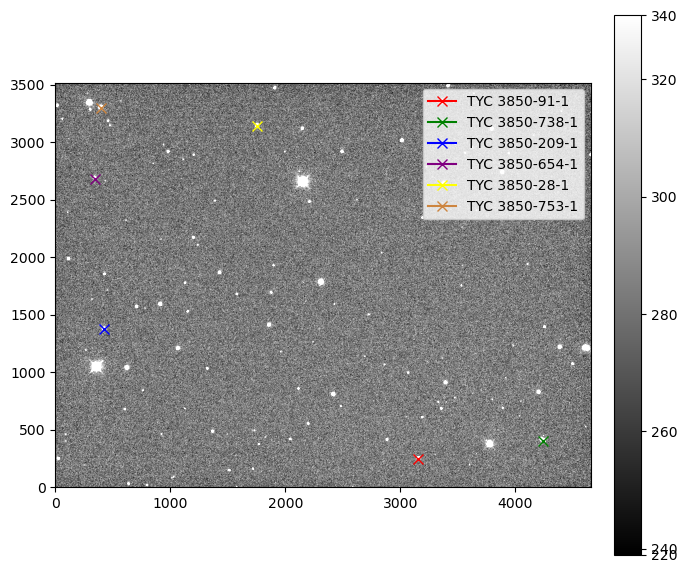

In [66]:
show_image(data[0], cmap= 'gray')
plt.plot(3156.391593667612, 249.55410761820283, marker = 'x', markersize = 7, color = 'red', label = 'TYC 3850-91-1')
plt.plot(4241.96236981832, 402.72851815537894, marker = 'x', markersize = 7, color = 'green', label = 'TYC 3850-738-1')
plt.plot(424.6783347656137, 1374.9292357923953, marker = 'x', markersize = 7, color = 'blue', label = 'TYC 3850-209-1')
plt.plot(345.5587801311043, 2684.932418493146, marker = 'x', markersize = 7, color = 'purple', label = 'TYC 3850-654-1')
plt.plot(1754.1996705503554, 3141.7386564632407, marker = 'x', markersize = 7, color = 'yellow', label = 'TYC 3850-28-1')
plt.plot(396.773250967703, 3296.865105632183, marker = 'x', markersize = 7, color = 'peru', label = 'TYC 3850-753-1')
plt.legend();

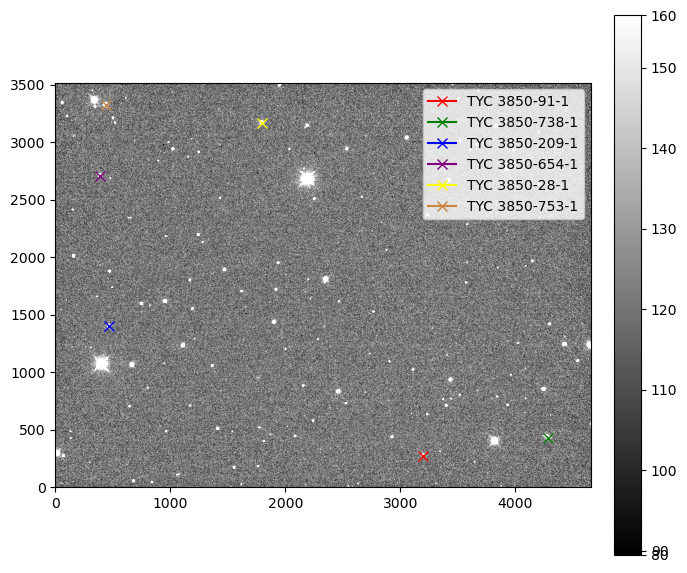

In [67]:
from convenience_functions import show_image
show_image(data[-1], cmap= 'gray')
plt.plot(3198.6312350867915, 275.13056433320367, marker = 'x', markersize = 7, color = 'red', label = 'TYC 3850-91-1')
plt.plot(4283.939991823673, 429.0982434051284, marker = 'x', markersize = 7, color = 'green', label = 'TYC 3850-738-1')
plt.plot(466.61276952428346, 1399.5207879354884, marker = 'x', markersize = 7, color = 'blue', label = 'TYC 3850-209-1')
plt.plot(387.837585300374, 2709.4622790306116, marker = 'x', markersize = 7, color = 'purple', label = 'TYC 3850-654-1')
plt.plot(1795.594390834655, 3166.587148487002, marker = 'x', markersize = 7, color = 'yellow', label = 'TYC 3850-28-1')
plt.plot(438.69571061757875, 3321.373967753316, marker = 'x', markersize = 7, color = 'peru', label = 'TYC 3850-753-1')
plt.legend();

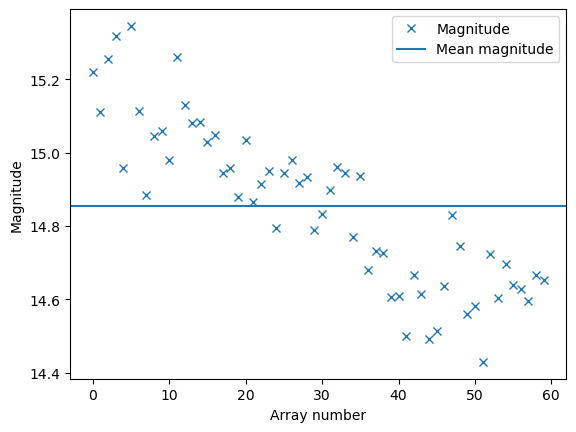

In [68]:
plt.plot(magnitude_list_standard_stars[0], 'x', label = 'Magnitude')
plt.axhline(np.nanmean(magnitude_list_standard_stars[0]), label ='Mean magnitude')
plt.xlabel('Array number')
plt.ylabel('Magnitude')
plt.legend();

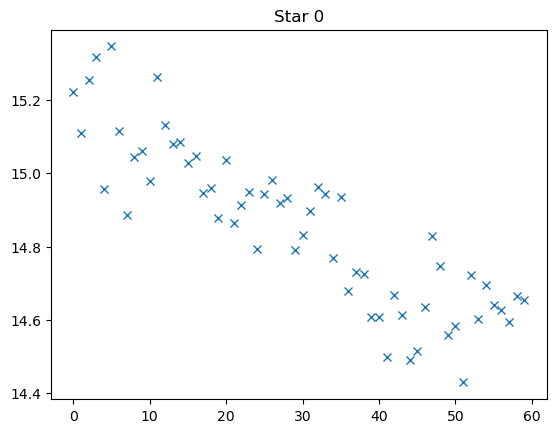

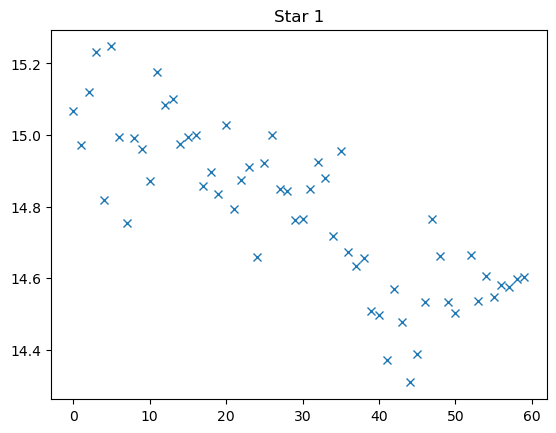

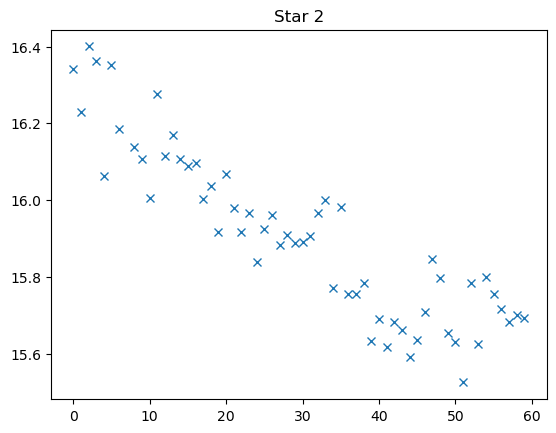

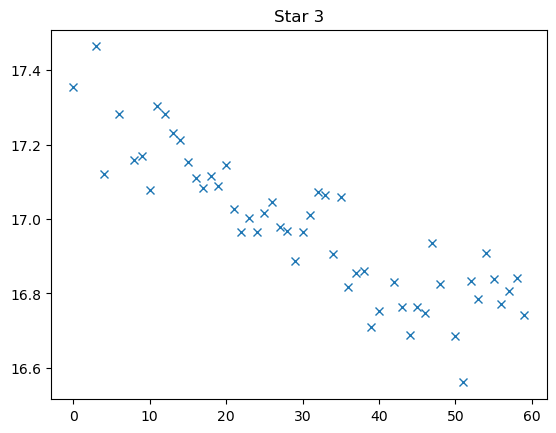

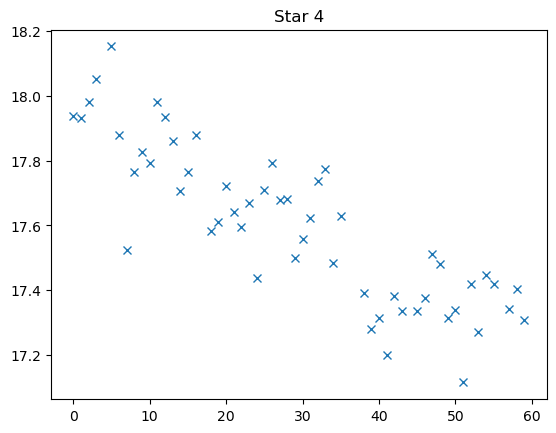

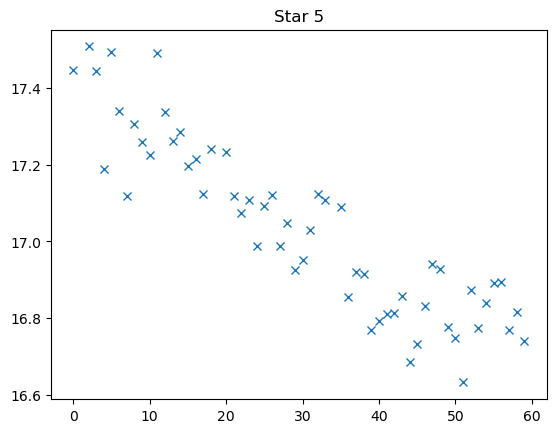

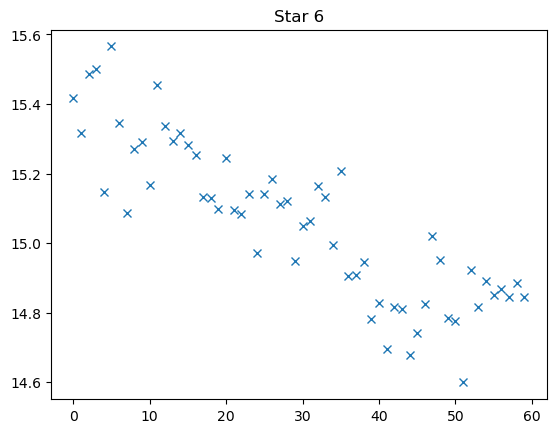

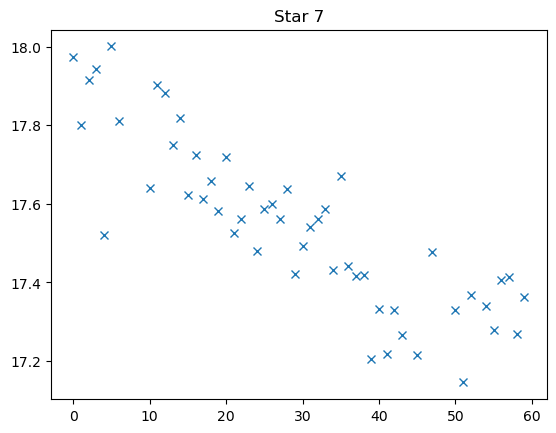

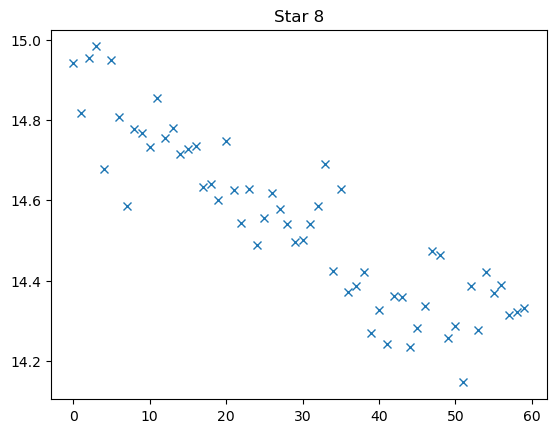

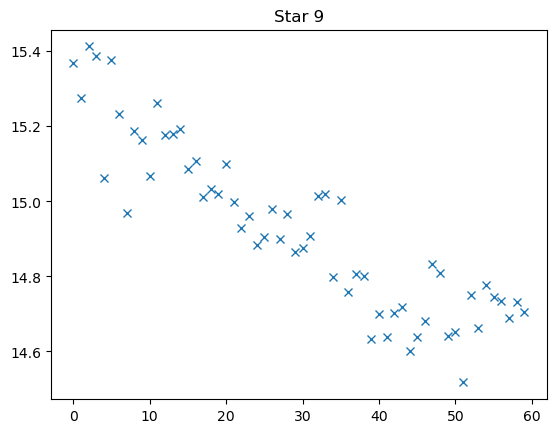

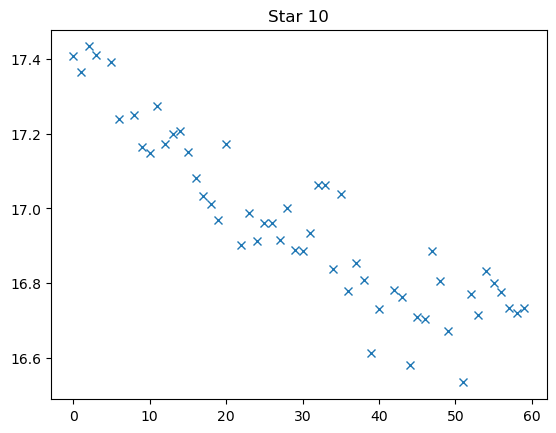

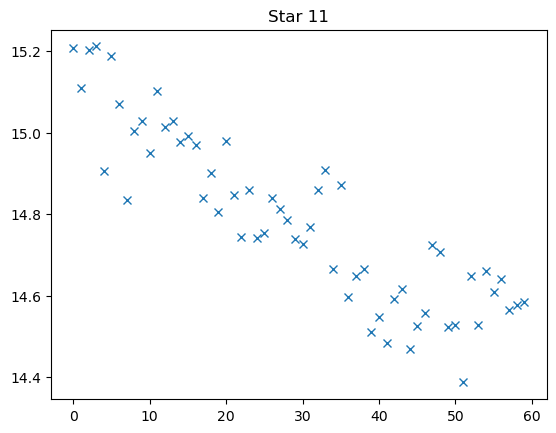

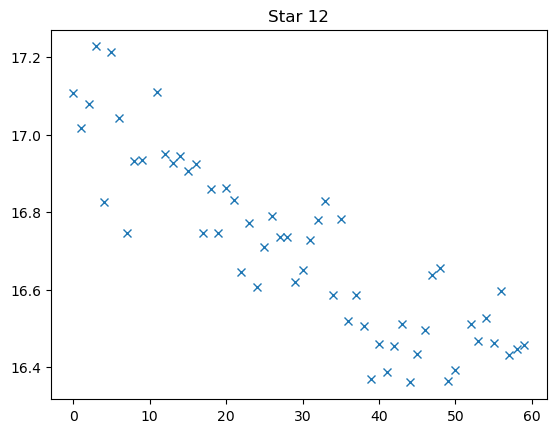

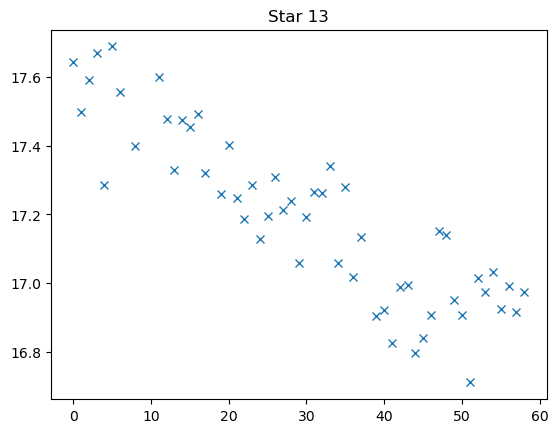

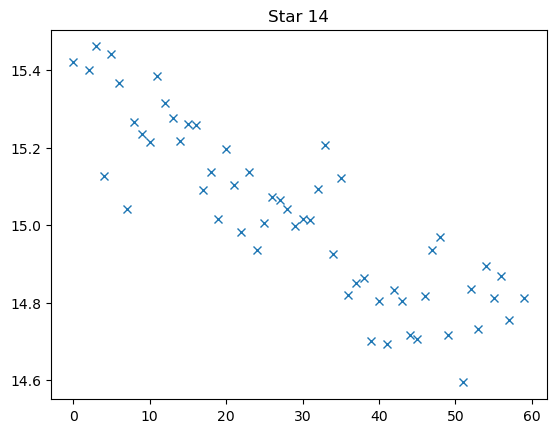

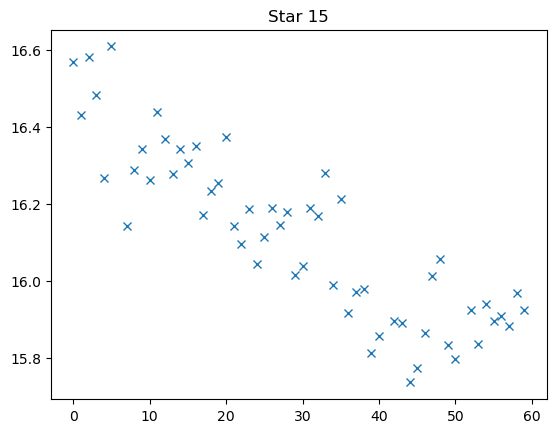

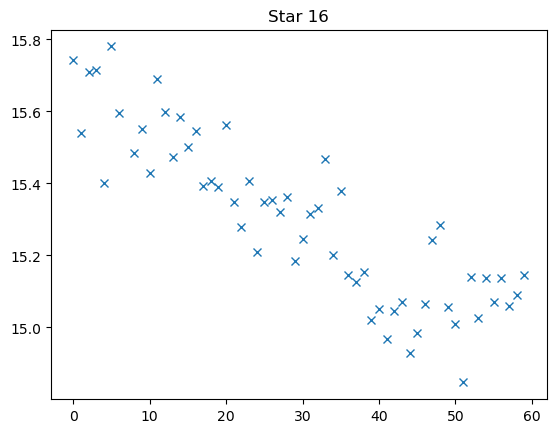

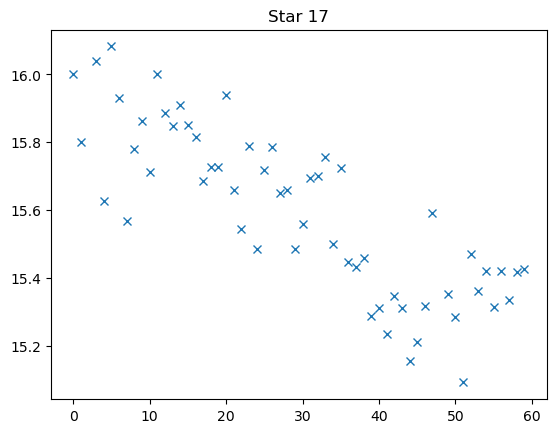

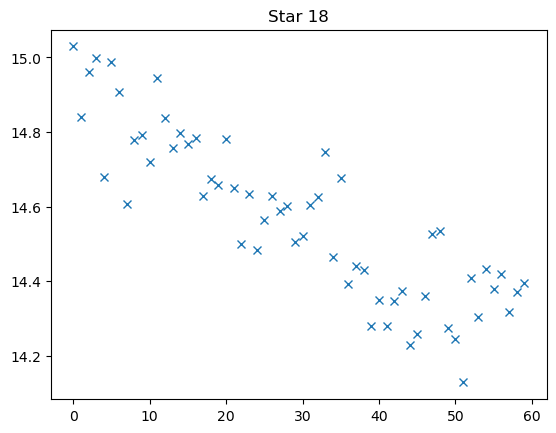

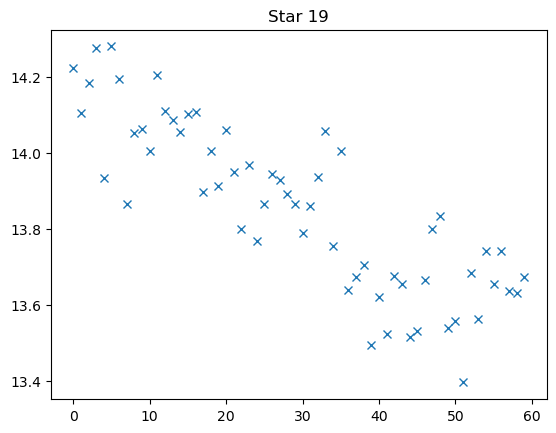

In [69]:
rows = 4
columns = 3
index = 0

for index, lst in enumerate(magnitude_list_standard_stars):
    plt.plot(lst, 'x')
    plt.title(f'Star {index}')
    plt.show()
    plt.close()

In [70]:
np.argmax(magnitude_list_standard_stars[9])

2

Text(0.5, 1.0, 'Offset star 0')

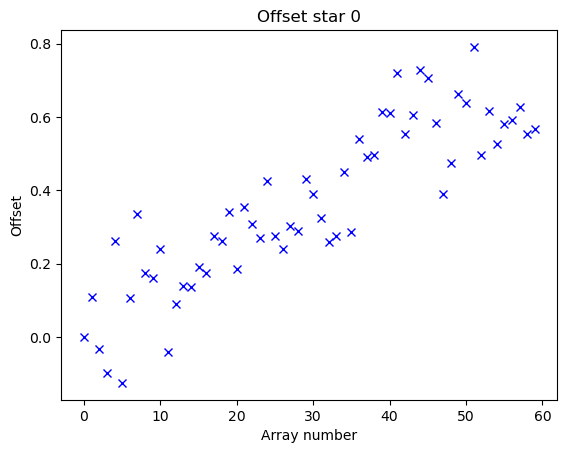

In [71]:
plt.plot(all_magnitude_offsets_standard_stars[0], 'x', color = 'blue', label ='Offset star 0')
plt.ylabel('Offset')
plt.xlabel('Array number')
plt.title('Offset star 0')

Text(0.5, 1.0, 'Offset star 3')

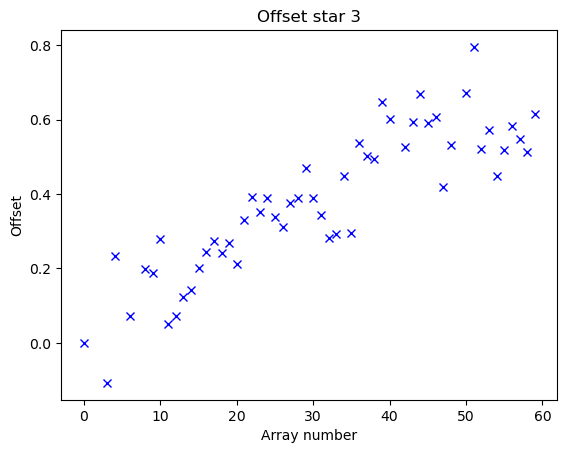

In [72]:
plt.plot(all_magnitude_offsets_standard_stars[3], 'x', color = 'blue', label ='Offset star 0')
plt.ylabel('Offset')
plt.xlabel('Array number')
plt.title('Offset star 3')

In [73]:
from operator import add
test_lst = list(map(add, flux_list_standard_stars[0], all_magnitude_offsets_standard_stars[0]))
test_lst

[8162.37517624467,
 9033.483268677064,
 7915.67516373101,
 7468.074734896902,
 10401.204559105447,
 7276.518943116173,
 9005.414022005854,
 11110.454801684426,
 9594.767451633,
 9468.527965059548,
 10197.372226155967,
 7861.192746818796,
 8865.125219150395,
 9287.6765810229,
 9257.717026125149,
 9737.11412597671,
 9580.244220408,
 10514.375733290119,
 10385.21954469914,
 11189.003341827261,
 9687.926825502487,
 11323.65008969785,
 10834.179144763506,
 10472.9166254728,
 12086.654596896911,
 10533.588896099918,
 10185.08423664088,
 10781.80364095608,
 10643.700808596046,
 12138.69499560263,
 11678.0523067171,
 10996.728233295991,
 10357.000171957587,
 10528.868323124225,
 12372.033978901489,
 10617.28633823226,
 13437.327538214735,
 12817.054574334266,
 12882.86128723452,
 14363.122291592486,
 14342.766979202388,
 15851.482636297795,
 13591.064954549613,
 14265.706462323502,
 15969.466367534567,
 15637.706805483649,
 13988.709520581946,
 11696.231034834454,
 12637.52870735946,
 15015.95

Text(0.5, 1.0, 'Corrected magnitude star 0')

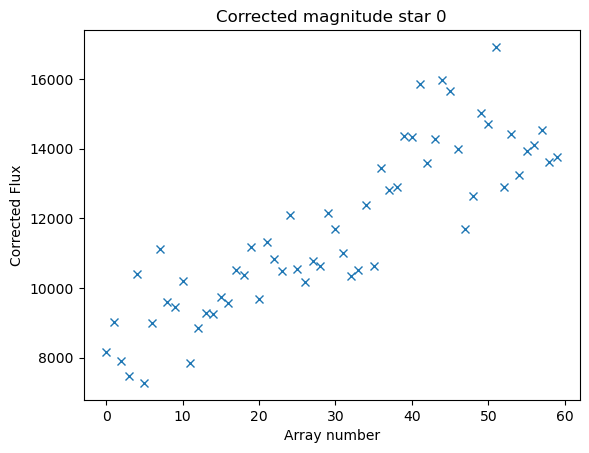

In [74]:
plt.plot(test_lst, 'x')
plt.ylabel('Corrected Flux')
plt.xlabel('Array number')
plt.title('Corrected magnitude star 0')

Text(0.5, 1.0, 'Corrected RV UMa magnitude')

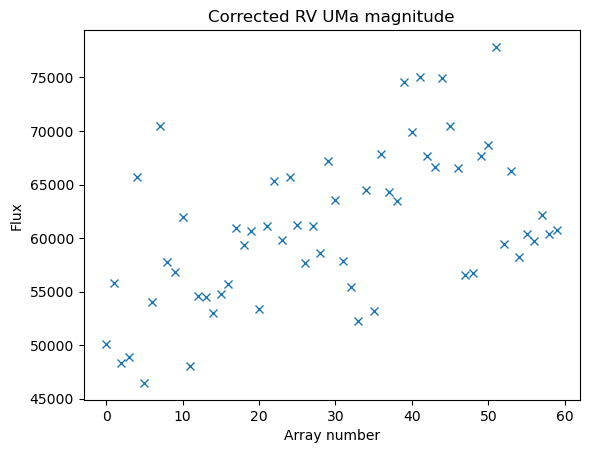

In [75]:
plt.plot(corrected_RV_UMa_flux, 'x')
plt.xlabel('Array number')
plt.ylabel('Flux')
plt.title('Corrected RV UMa magnitude')

In [76]:
for lst in all_magnitude_offsets_standard_stars:
    print(lst[24])

0.4261856116038132
0.4072183968117269
0.503321431827084
0.39010204124397774
0.5018072647078746
0.4579770063297417
0.4444484133775717
0.49379072117862677
0.45157856501552907
0.48485026578030244
0.49722577148730096
0.46731650643597256
0.5006302555794022
0.5132843734675383
0.48339025693783455
0.5245753662767711
0.5347177199064923
0.5140893303795302
0.545384319514751
0.45635702831493496


In [77]:
mean_magnitude_offsets

array([ 0.        ,  0.11968884, -0.00595134, -0.03768798,  0.30371531,
       -0.05684024,  0.10317545,  0.37368863,  0.188263  ,  0.1794159 ,
        0.25934458,  0.03530273,  0.1330009 ,  0.17543891,  0.17499913,
        0.20934253,  0.19604429,  0.3306313 ,  0.29119837,  0.34790693,
        0.20252908,  0.34552186,  0.41410736,  0.32079644,  0.47991253,
        0.36934597,  0.31344356,  0.38019292,  0.36388138,  0.47878192,
        0.44551365,  0.38397632,  0.32459725,  0.2786136 ,  0.51044001,
        0.30864347,  0.57678334,  0.54525792,  0.5416361 ,  0.7014828 ,
        0.64624018,  0.72936852,  0.6152509 ,  0.62848006,  0.76352571,
        0.71011715,  0.63250581,  0.46387501,  0.48886946,  0.68245331,
        0.68514669,  0.84226588,  0.56449105,  0.66284828,  0.5538556 ,
        0.60808447,  0.57868082,  0.63803422,  0.60907176,  0.61317753])

In [78]:
find_nearest(test_sources_first_array, excluding_duplicates(image_trimmer(find_sources(data[25]), data[25]), 9))

{0: 0,
 1: 1,
 2: 2,
 3: 4,
 4: 5,
 5: 6,
 6: 8,
 7: 10,
 8: 11,
 9: 12,
 10: 13,
 11: 14,
 12: 18,
 13: 21,
 14: 22,
 15: nan,
 16: nan,
 17: 23,
 18: 24,
 19: 27,
 20: 28,
 21: 33,
 22: nan,
 23: 36,
 24: 40,
 25: 41,
 26: 42,
 27: nan,
 28: 47,
 29: nan,
 30: nan,
 31: 49,
 32: 51,
 33: 52,
 34: 54,
 35: 55}

In [79]:
excluding_duplicates(image_trimmer(find_sources(data[25]), data[25]), 9)

xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  sky  \
0   3179.569695   207.238281   0.581001   -0.449862    0.018679   121  0.0   
1   3797.829343   330.858545   0.454976   -0.428773   -0.001597   121  0.0   
2   4264.617219   361.512746   0.529010   -0.336433    0.024046   121  0.0   
3   1851.391067   389.914890   0.852466    0.024240    0.169395   121  0.0   
4   1392.684536   440.930513   0.615301   -0.227475    0.143513   121  0.0   
5   2222.790565   508.083617   0.623333   -0.329780   -0.066008   121  0.0   
6   3213.699696   563.695916   0.269123   -0.288934    0.110673   121  0.0   
7   3377.926678   639.710658   0.575612   -0.408480    0.038880   121  0.0   
8   3352.262449   695.590584   0.490000   -0.624013   -0.192304   121  0.0   
9   3496.226808   735.095520   0.668335   -0.440467    0.184110   121  0.0   
10  2440.403630   762.188976   0.576722   -0.276694    0.139844   121  0.0   
11  2136.982956   812.240185   0.721256   -0.264870    0.098119   121  0.0   
12  3414.230352   864.920772   0.476471   -0.373823    0.100383   121  0.0   
13  3089.332619   952.082703   0.231234   -0.183175    0.229290   121  0.0   
14   382.223797  1000.923612   0.292173   -0.140830   -0.235844   121  0.0   
15  3261.024828  1039.909296   0.510519    0.322608   -0.058665   121  0.0   
16  2713.995771  1093.057844   0.297089   -0.127753   -0.233657   121  0.0   
17  1983.314611  1133.737703   0.396325   -0.279818    0.161144   121  0.0   
18  1089.285857  1162.528502   0.543804   -0.129643    0.162405   121  0.0   
19  2264.585120  1218.771301   0.246591    0.302344    0.454313   121  0.0   
20  3511.418892  1302.129612   0.293132    0.463360   -0.791257   121  0.0   
21   447.346461  1332.015142   0.560470   -0.170438    0.142972   121  0.0   
22  1881.402900  1366.640014   0.512153   -0.187897    0.221620   121  0.0   
23  1174.386594  1483.420376   0.430236   -0.073306    0.140620   121  0.0   
24   936.704397  1547.037856   0.515457   -0.178747    0.145761   121  0.0   
25   344.164506  1588.571695   0.254965   -0.673670   -0.027216   121  0.0   
26  1900.399373  1648.350277   0.785867   -0.116184    0.170349   121  0.0   
27  2331.045100  1738.385864   0.575239   -0.120963    0.198368   121  0.0   
28  1452.368077  1821.142179   0.628728   -0.097762    0.178577   121  0.0   
29  1920.936011  1882.653311   0.416921   -0.111356    0.316241   121  0.0   
30  4319.398491  1918.401969   0.309551    0.399265    0.168063   121  0.0   
31  2860.066289  1991.891621   0.284538    0.068266    0.082377   121  0.0   
32  1263.483204  2060.934073   0.369194   -0.054600    0.070115   121  0.0   
33  1224.617182  2124.969895   0.509249   -0.198981    0.201614   121  0.0   
34  2733.248530  2157.136882   0.772028   -0.027663   -0.608954   121  0.0   
35  3925.713687  2225.833534   0.227748    0.496101   -0.704862   121  0.0   
36  3214.612763  2297.778229   0.302833   -0.144580    0.043381   121  0.0   
37  3397.089721  2410.889399   0.943483   -0.117010    0.042197   121  0.0   
38  2232.547089  2437.981535   0.375801   -0.122665    0.217461   121  0.0   
39  4183.810579  2564.522541   0.886469   -0.009817    0.017272   121  0.0   
40  2174.024536  2610.965689   0.292277    0.023481   -0.457904   121  0.0   
41   368.200461  2642.013510   0.465024   -0.125784    0.337652   121  0.0   
42  3904.753734  2692.819131   0.436132   -0.148942    0.048541   121  0.0   
43  3250.077368  2741.274758   0.933638   -0.214023    0.110424   121  0.0   
44  2273.410288  2770.863555   0.560238   -0.479284   -0.694020   121  0.0   
45  1136.289813  2802.718259   0.638486   -0.516542    0.513281   121  0.0   
46  1227.854672  2844.402170   0.325456   -0.182977    0.144055   121  0.0   
47  2515.349426  2871.598465   0.616477   -0.002164    0.145478   121  0.0   
48  3644.649154  2908.854444   0.670368   -0.316456    0.100407   121  0.0   
49  3034.396564  2967.634127   0.540554   -0.037522    0.075485   121  0.0   
50  1857.882889  3032.679665

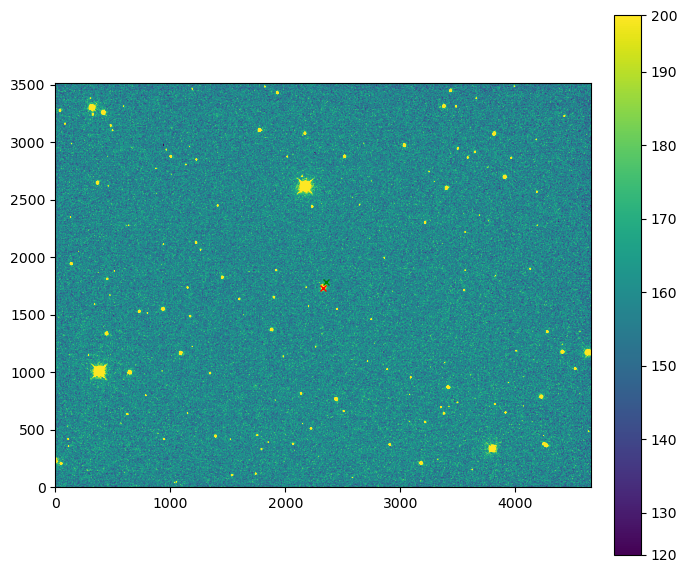

In [80]:
show_image(data[25])
plt.plot(2351, 1784, marker = 'x', markersize = 5, color = 'green')
plt.plot(2331, 1738, marker = 'x', markersize = 5, color = 'red')

# Plotting the arrays with time in the x - axis

In [81]:
import datetime

times = [datetime.datetime.strptime(header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S.%f') for header in headers]
t = [(time - times[0]).total_seconds() for time in times]

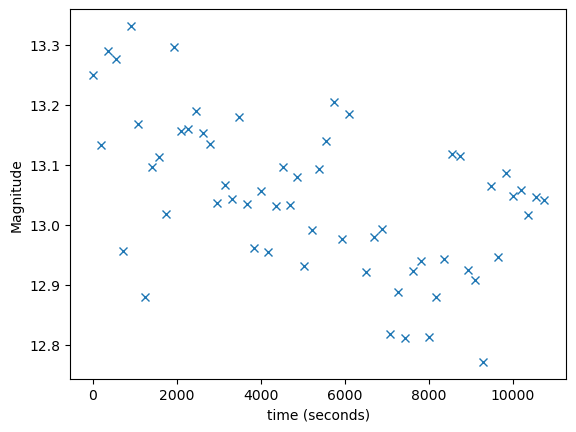

In [82]:
plt.plot(t, corrected_RV_UMa_magnitude, 'x')
plt.xlabel('time (seconds)')
plt.ylabel('Magnitude');

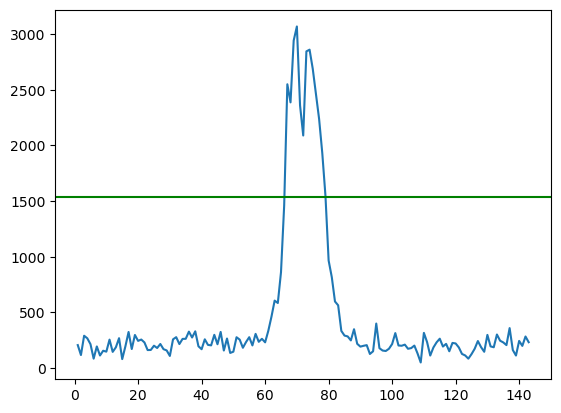

In [83]:
fwhm_data = pd.read_csv('ds9.dat', sep = ' ', header = None)
plt.plot(fwhm_data[0], fwhm_data[1])
plt.axhline(max(fwhm_data[1])/2, color = 'green')

# TO DO

Once the algorithm has been done for all the arrays, check on a plot how the magnitude changes. The last star detected on the first array with the current parameters is very close to two other stars, so that when the last arrays are being ran its nearest neighbour is actually another star. We do not need this star for the photometry, so just ignore it. The 5th star in the first array is RV UMa in the first day. In the second it's number 3

In [ ]:
# TO DO
# 1. Test flux lists with all 55 arrays
# 2. Plot the fluxes across all the arrays
# 3. Check if any stars are confused with others
# 4. Grab the positions of all the stars in the array and their mappings back to the first array
# 5. Run the same procedure on the other days



In [ ]:
all_sources_all_arrays = list() # list with the sources on all the arrays that correspond to sources in the first image

all_sources_all_arrays.append(list(dictionary_list[0].keys()))
for index in range(len(dictionary_list)):
    sources_n_array = list() # What the sources in array n correspond to in the first array
    for key in dictionary_list[0].keys():
        sources_n_array.append(dictionary_list[index][key])
    all_sources_all_arrays.append(sources_n_array)

In [ ]:
positions_dict = dict()

for index, lst in enumerate(all_sources_all_arrays):
    found_sources = find_sources(data[index])
    trimmed_image = image_trimmer(found_sources, data[index])
    final_df = excluding_duplicates(trimmed_image, 9)
    for position_first_array, position_nth_array in enumerate(lst):
        if position_first_array in positions_dict.keys():
            positions_dict[position_first_array].append(position_nth_array)
        else:
            positions_dict[position_first_array] = list()

In [ ]:
flux_lists = list()
for key, chain in positions_dict.items():
    fluxes = list()
    for i in range(len(chain)):
        if i == 0:
            found_sources = find_sources(data[i])
            trimmed_sources = image_trimmer(found_sources, data[i])
            sources_no_duplicates = excluding_duplicates(trimmed_sources, 9)
            fluxes.append(sources_no_duplicates.iloc[key]['flux'])
        else:
            j = chain[i-1]
            if j is not np.nan:
                found_sources = find_sources(data[i])
                trimmed_sources = image_trimmer(found_sources, data[i])
                sources_no_duplicates = excluding_duplicates(trimmed_sources, 9)
                fluxes.append(sources_no_duplicates.iloc[j]['flux'])
            else:
                fluxes.append(np.nan)
    flux_lists.append(fluxes)